The tutorials use PyTorch. You will need to load the following dependencies.

In [1]:
# This specific version of torchvision is needed to download the mnist set
#!pip3 install torch torchvision

In [2]:
import random

import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import skimage.transform
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
from IPython import display
from torchvision import datasets, transforms

# Tutorial 2b: Batch Normalization

The code below may be helpful in visualizing PyTorch tensors as images.

In [3]:
%matplotlib inline


def show(img):
    """Show PyTorch tensor img as an image in matplotlib."""
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    plt.grid(False)
    plt.gca().axis("off")


def display_thumb(img):
    display.display(transforms.Resize(128)(img))

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Load MNIST and define train/test functions as before. Please make sure you read the code carefully and understand what it is doing.

In [5]:
# Load the training and test dataset.
mnist_train = datasets.MNIST(
    "/tmp/mnist", train=True, download=True, transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    "/tmp/mnist", train=False, download=True, transform=transforms.ToTensor()
)

# Size of the batches the data loader will produce.
batch_size = 64

# This creates the dataloaders.
train_loader = torch.utils.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    mnist_test, batch_size=batch_size, shuffle=False
)

In [6]:
def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model."""

    # Make sure model is in training mode.
    model.train()

    # Move model to the device (CPU or GPU).
    model.to(device)

    # Exponential moving average of the loss.
    ema_loss = None

    # Loop over epochs.
    for epoch in range(num_epochs):

        # Loop over data.
        for batch_idx, (data, target) in enumerate(data_loader):

            # Forward pass.
            output = model(data.to(device))
            loss = criterion(output.to(device), target.to(device))

            # Backward pass.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # NOTE: It is important to call .item() on the loss before summing.
            if ema_loss is None:
                ema_loss = loss.item()
            else:
                ema_loss += (loss.item() - ema_loss) * 0.01

        # Print out progress the end of epoch.
        print(
            "Train Epoch: {} \tLoss: {:.6f}".format(epoch, ema_loss),
        )


def test(model, data_loader):
    """Measures the accuracy of a model on a data set."""
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0

    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():

        # Loop over test data.
        for data, target in data_loader:

            # Forward pass.
            output = model(data.to(device))

            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)

            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100.0 * correct / len(data_loader.dataset)
    print(f"Accuracy: {correct} / {len(data_loader.dataset)} ({percent:.0f}%)")
    return percent

In the last tutorial, you implemented a naive convolution. In this section you will implement your own version of forward pass of nn.Conv2d without using any of PyTorch's (or numpy's) pre-defined convolutional functions.

In [7]:
def conv_forward_naive(x, w, b, conv_param):
    """
    A naive Python implementation of a convolutional layer.
    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width WW.
    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input.

    During padding, 'pad' zeros should be placed symmetrically (i.e., equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.
    Returns an array.
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    """
    out = None

    N, C, H, W = x.shape
    num_filters, _, filter_height, filter_width = w.shape
    stride, pad = conv_param["stride"], conv_param["pad"]

    # Check dimensions.
    assert (W + 2 * pad - filter_width) % stride == 0, "width does not work"
    assert (H + 2 * pad - filter_height) % stride == 0, "height does not work"

    ###########################################################################
    # TODO: Implement the forward pass of a convolutional layer without using #
    #       nn.Conv2D or other implementations of convolutions. Instead, use  #
    #       standard for- and while-loops to iterate over the tensors.        #
    #                                                                         #
    # Hint: you can use the function torch.nn.functional.pad for padding.     #
    ###########################################################################
    
    #pad_x = torch.nn.functional.pad(x, (pad, pad, pad, pad))
    pad_x = torch.zeros((N,C,H + 2 * pad,W + 2 * pad))
    pad_x[:,:,pad:-pad,pad:-pad] = x[:,:,:,:]
    
    output_shape = 1 + (W + 2 * pad - filter_width) // stride
    
    output_img = torch.zeros((N,C,output_shape, output_shape))
    z = filter_height
    
    
    for i in range(N):
        for j in range(C):
            p = 0
            for k in range(output_shape):
                q = 0
                for l in range(output_shape):
                    mat = pad_x[i,:,p:p+z, q: q + z]
                    q += stride
                    output_img[i,j,k,l] = torch.sum(mat * w[j])
                p += stride 
    
    transformed_b = torch.zeros((N, C, output_shape, output_shape))
    for i in range(N):
        for j in range(C):
            transformed_b[:, j, :, :] = b[j]

    return output_img + transformed_b

You can test your implementation by running the following testing code:

In [8]:
# Make convolution module.
w_shape = (3, 3, 4, 4)
w = torch.linspace(-0.2, 0.3, steps=torch.prod(torch.tensor(w_shape))).reshape(w_shape)
b = torch.linspace(-0.1, 0.2, steps=3)

# Compute output of module and compare against reference values.
x_shape = (2, 3, 4, 4)
x = torch.linspace(-0.1, 0.5, steps=torch.prod(torch.tensor(x_shape))).reshape(x_shape)
out = conv_forward_naive(x, w, b, {"stride": 2, "pad": 1})

correct_out = torch.tensor(
    [
        [
            [[-0.08759809, -0.10987781], [-0.18387192, -0.2109216]],
            [[0.21027089, 0.21661097], [0.22847626, 0.23004637]],
            [[0.50813986, 0.54309974], [0.64082444, 0.67101435]],
        ],
        [
            [[-0.98053589, -1.03143541], [-1.19128892, -1.24695841]],
            [[0.69108355, 0.66880383], [0.59480972, 0.56776003]],
            [[2.36270298, 2.36904306], [2.38090835, 2.38247847]],
        ],
    ]
)

# Compare your output to ours; difference should be around e-8
print("Testing conv_forward_naive")
rel_error = ((out - correct_out) / (out + correct_out + 1e-6)).mean()
print("difference: ", rel_error)
if abs(rel_error) < 1e-6:
    print("Nice work! Your implementation of a convolution layer works correctly.")
else:
    print(
        "Something is wrong. The output was expected to be {} but it was {}".format(
            correct_out, out
        )
    )

Testing conv_forward_naive
difference:  tensor(3.0298e-08)
Nice work! Your implementation of a convolution layer works correctly.



We will now replace the logistic regressor from the last tutorial by a small convolutional network with two convolutional layers and a linear layer, and ReLU activations in between the layers. Implement the model and use the same functions as before to train and test the convolutional network.

In [9]:
class ConvolutionalNetwork(nn.Module):
    """Simple convolutional network."""

    def __init__(self, image_side_size, num_classes, in_channels=1):
        super(ConvolutionalNetwork, self).__init__()
        self.image_side_size = image_side_size
        self.num_classes = num_classes
        self.in_channels = in_channels

        # Fill these in:
        ##########################################################################
        # TODO: Implement a convulutional and a linear part.                     #
        # Hint: see forward() to understand how they should work together.       #
        ##########################################################################
        self.conv_network = self.conv_network = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU())
        
        conv_output = self.conv_output_size()
        
        self.linear = nn.Linear(conv_output, num_classes)
        
    def conv_output_size(self):
        conv_output = ((self.image_side_size - 3 + 2*0) // 2 + 1)
        conv_output = ((conv_output - 3 + 2*0) // 2 + 1)
        return conv_output * conv_output * 32
    
    def forward(self, x):
        x = self.conv_network(x)
        x = self.linear(x.view(x.size(0), -1))
        return x


# Create and train convolutional network.
# The accuracy should be around 96%.
conv_model = ConvolutionalNetwork(28, 10)
###########################################################################
# TODO: Create criterion and optimize here.                               #
###########################################################################
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_model.parameters(), lr=0.1)

train(conv_model, criterion, train_loader, optimizer, num_epochs=5)
test(conv_model, test_loader)

Train Epoch: 0 	Loss: 0.177462
Train Epoch: 1 	Loss: 0.105559
Train Epoch: 2 	Loss: 0.093759
Train Epoch: 3 	Loss: 0.069313
Train Epoch: 4 	Loss: 0.066218
Accuracy: 9743 / 10000 (97%)


97.43

Inspect the filters in the first layer of the trained convolutional network. What do they look like? Why?

* Some filters may resemble edge detectors, capturing variations in intensity or color across the image.

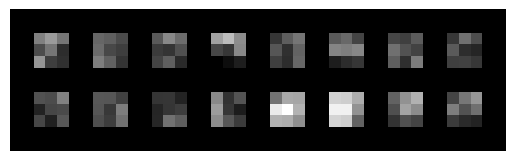

In [10]:
first_conv = list(conv_model.conv_network.children())[0]
show(
    torchvision.utils.make_grid(
        first_conv.weight,
        normalize=True,
        nrow=8,
    )
)

## Batch Normalization


Batch normalization is tenchique that allows to make training more stable fast [1].

Below we define a convolutional network with 3 layers. Before each ReLU layer we insert a BatchNorm2d layer if `use_batch_norm` is `True`. This improves the convergence as guarantees as values have the same variance asn zero-means. As a result on average exactly half of the values will be nulled by ReLU.

[1] Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." arXiv preprint arXiv:1502.03167 (2015).

**Task**. Go ahead and add batch normalization layer.

In [11]:
class ConvolutionalNetworkWithBN(nn.Module):
    """Convolutional network uses batch normalization when `use_batch_norm` is `True`."""

    def __init__(self, use_batch_norm=False):
        super().__init__()
        num_channels = 8
        self.use_batch_norm = use_batch_norm

        # We define all our layers in a single Sequential. If use_batch_norm is
        # True, we'd like maybe_batch_norm_layer to produce a batchnorm layer.
        self.conv = nn.Sequential(
            # 1x28x28 -> 8x24x24.
            nn.Conv2d(1, num_channels, kernel_size=5),
            # 8x24x24 -> 8x12x12.
            nn.MaxPool2d(2),
            self.maybe_batch_norm_layer(num_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),
            self.maybe_batch_norm_layer(num_channels),
            nn.ReLU(inplace=True),
            # 8x12x12 -> 8x8x8.
            nn.Conv2d(num_channels, num_channels, kernel_size=5),
            # 8x8x8 -> 8x4x4.
            nn.MaxPool2d(2),
            self.maybe_batch_norm_layer(num_channels),
            nn.ReLU(inplace=True),
        )
        self.linear = nn.Linear(num_channels * 4**2, 10)

    def maybe_batch_norm_layer(self, num_channels):
        if self.use_batch_norm:
            ###########################################################################
            # TODO: Add batch norm layer                                              #
            # Put your code between START_GRADING and END_GRADING.                    #
            ###########################################################################
            #START_GRADING
            return nn.BatchNorm2d(num_channels)
            #END_GRADING.
        else:
            # This layer will copy its input to the output.
            return nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.linear(x.view(x.size(0), -1))
        return x

To see how batch normalization improves stability, let's try to train the neural network with different learning rates and check the accuracies.

In [12]:
for lr in 0.3, 0.1, 0.03, 0.01, 0.003:
    conv_model = ConvolutionalNetworkWithBN()
    optimizer = torch.optim.SGD(conv_model.parameters(), lr=lr)
    train(conv_model, nn.CrossEntropyLoss(), train_loader, optimizer, num_epochs=1)
    accuracy = test(conv_model, test_loader)
    if accuracy > 96:
        print(f"##### lr={lr} leads to GOOD accuracy (no batch normalization)")
    elif accuracy > 90:
        print(f"##### lr={lr} leads to DECENT accuracy (no batch normalization)")
    else:
        print(f"##### lr={lr} leads to BAD accuracy (no batch normalization)")

Train Epoch: 0 	Loss: 0.105003
Accuracy: 9757 / 10000 (98%)
##### lr=0.3 leads to GOOD accuracy (no batch normalization)
Train Epoch: 0 	Loss: 0.127481
Accuracy: 9634 / 10000 (96%)
##### lr=0.1 leads to GOOD accuracy (no batch normalization)
Train Epoch: 0 	Loss: 0.211976
Accuracy: 9400 / 10000 (94%)
##### lr=0.03 leads to DECENT accuracy (no batch normalization)
Train Epoch: 0 	Loss: 0.410862
Accuracy: 8945 / 10000 (89%)
##### lr=0.01 leads to BAD accuracy (no batch normalization)
Train Epoch: 0 	Loss: 2.273959
Accuracy: 2069 / 10000 (21%)
##### lr=0.003 leads to BAD accuracy (no batch normalization)


As you can see learning rate should be in a narrow region to get GOOD result.

Now let's try to run the same batch normalization. Before running the code you should finish TODO in ConvolutionalNetworkWithBN code. If your code is correct, then accuracies will improve.

In [13]:
for lr in 0.3, 0.1, 0.03, 0.01, 0.003:
    conv_model = ConvolutionalNetworkWithBN(use_batch_norm=True)
    optimizer = torch.optim.SGD(conv_model.parameters(), lr=lr)
    train(conv_model, nn.CrossEntropyLoss(), train_loader, optimizer, num_epochs=1)
    accuracy = test(conv_model, test_loader)
    if accuracy > 96:
        print(f"##### lr={lr} leads to GOOD accuracy (with batch normalization)")
    elif accuracy > 90:
        print(f"##### lr={lr} leads to DECENT accuracy (with batch normalization)")
    else:
        print(f"##### lr={lr} leads to BAD accuracy (with batch normalization)")
    if lr >= 0.01:
        assert (
            accuracy > 90
        ), "Accuracy is too low. Check that your BatchNorm implementation is correct!"

Train Epoch: 0 	Loss: 0.068699
Accuracy: 9837 / 10000 (98%)
##### lr=0.3 leads to GOOD accuracy (with batch normalization)
Train Epoch: 0 	Loss: 0.065399
Accuracy: 9828 / 10000 (98%)
##### lr=0.1 leads to GOOD accuracy (with batch normalization)
Train Epoch: 0 	Loss: 0.102613
Accuracy: 9765 / 10000 (98%)
##### lr=0.03 leads to GOOD accuracy (with batch normalization)
Train Epoch: 0 	Loss: 0.172459
Accuracy: 9655 / 10000 (97%)
##### lr=0.01 leads to GOOD accuracy (with batch normalization)
Train Epoch: 0 	Loss: 0.521752
Accuracy: 9249 / 10000 (92%)
##### lr=0.003 leads to DECENT accuracy (with batch normalization)


**Question [optional]:** Replace the batch normalization layer in your network by your own implementation. Confirm your batch-normalization implementation is correct.

In [14]:
class MyBatchNorm2d(nn.Module):
    """Simple implementation of batch normalization."""

    def __init__(self, num_channels, momentum=0.1, epsilon=1e-5):
        super(MyBatchNorm2d, self).__init__()
        self.num_channels = num_channels

        # Initialize bias and gain parameters.
        self.gamma = nn.Parameter(torch.ones(1, num_channels, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_channels, 1, 1))

        # Initialize moving averages.
        self.epsilon = epsilon
        self.momentum = momentum
        self.register_buffer("running_mean", torch.zeros((1, num_channels, 1, 1)))
        self.register_buffer("running_var", torch.ones((1, num_channels, 1, 1)))

    def forward(self, x):
        # Check that input is of correct size.
        assert x.dim() == 4, "input should be NCHW"
        assert x.size(1) == self.gamma.numel()

        ########################################################################
        # TODO: Add batch norm layer implementation.                           #
        # You code should:                                                     #
        #   * Compute mean and var.                                            #
        #   * Update running_mean and running_var.                             #
        #   * Apply mean - variance normalization to x.                        #
        # Put your code between START_GRADING and END_GRADING.                 #
        ########################################################################
        if mode is True:
            mean_x = torch.mean(x,dim=(0,2,3),keepdims=True)
            var_x = torch.var(x, dim=(0,2,3),keepdims=True)
            
            self.running_mean = (1 - self.momentum)* self.running_mean + self.momentum * mean_x 
            self.running_var = (1 - self.momentum)* self.running_var + self.momentum * var_x
            
            hat_x = (x - mean_x ) * 1.0 / torch.sqrt(var_x + self.epsilon)
            out = self.gamma * hat_x + self.beta 
            
        else:
            hat_x = (x - self.running_mean ) * 1.0 / torch.sqrt(self.running_var + self.epsilon)
            out = self.gamma * hat_x + self.beta 
            
        return out

In [15]:
# Use this code to test if your implementation is correct.
batch_size, num_channels, im_size = 32, 8, 6
batchnorm1 = nn.BatchNorm2d(num_channels)
batchnorm2 = MyBatchNorm2d(num_channels)
for key, param in batchnorm1.named_parameters():
    if key == "weight":
        param.data.fill_(1.0)  # undo random initialization in nn.BatchNorm2d
for mode in [True]:#, False]:  # test in training and evaluation mode
    batchnorm1.train(mode=mode)
    batchnorm2.train(mode=mode)
    for _ in range(5):
        x = torch.randn(batch_size, num_channels, im_size, im_size) + 10.0
        out1 = batchnorm1(x)
        out2 = batchnorm2(x)
        assert (
            batchnorm1.running_mean - batchnorm2.running_mean.squeeze()
        ).abs().max() < 1e-5, "running mean is incorrect (%s mode)" % (
            "train" if mode else "eval"
        )
        assert (
            batchnorm1.running_var - batchnorm2.running_var.squeeze()
        ).abs().max() < 1e-5, "running variance is incorrect (%s mode)" % (
            "train" if mode else "eval"
        )
        assert (
            out1 - out2
        ).abs().max() < 5e-3, "normalized output is incorrect (%s mode)" % (
            "train" if mode else "eval"
        )
print("All OK!")

All OK!
